In [27]:
import os
from matplotlib import pyplot as plt
import mysql.connector
import numpy as np
from skimage import feature
import cv2
from PIL import Image
def convert_to_rgb(image):
    """Chuyển đổi ảnh về dạng RGB nếu nó không phải là RGB."""
    if len(image.shape) == 2:
        rgb_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif len(image.shape) == 3:
        if image.shape[2] == 4:
            rgb_image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGB)
        elif image.shape[2] == 3:
            rgb_image = image
        else:
            raise ValueError("Không xác định định dạng ảnh đầu vào.")
    else:
        raise ValueError("Không xác định định dạng ảnh đầu vào.")
    
    return rgb_image

In [28]:
def my_calcHist(image, channels, histSize, ranges):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv_image], channels, None, histSize, ranges)
    hist /= (hsv_image.shape[0] * hsv_image.shape[1])
    hist = hist / hist.max()
    return hist

In [29]:
def convert_image_rgb_to_gray(img_rgb):
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img_gray)
    return img_clahe

In [30]:
def hog_feature(gray_img):
    (hog_feats, hogImage) = feature.hog(
        gray_img,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        transform_sqrt=True,
        block_norm="L2",
        visualize=True,
    )
    hog_feats /= np.linalg.norm(hog_feats)
    
    return hog_feats, hogImage

In [31]:
def edge_feature(image):
    
    edges = cv2.Canny(image, 100, 200,
                 apertureSize = 5,  
                 L2gradient = True)
    return edges.flatten()/255, edges

In [32]:
def layout_feature(image):
    image = image /255
    grid_size = 10
    height, width = image.shape
    cell_height, cell_width = height // grid_size, width // grid_size
    layout_features = []
    for i in range(grid_size):
        for j in range(grid_size):
            cell = image[i*cell_height:(i+1)*cell_height, j*cell_width:(j+1)*cell_width]
            cell_feature = np.mean(cell)
            layout_features.append(cell_feature)
    # return np.array(layout_features)
    return np.array(layout_features).reshape((grid_size, grid_size))

In [33]:
def feature_extraction(img):
    channels = [0, 1, 2]
    histSize = [28, 32, 24]
    ranges = [0, 180, 0, 256, 0, 256]
    hist = my_calcHist(img, channels, histSize, ranges)
    embedding = np.array(hist.flatten()) / (256*256)
    gray_image = convert_image_rgb_to_gray(img)
    embedding_hog, hog_img = list(hog_feature(gray_image))
    
    # Edge detection
    edge_feat = edge_feature(gray_image)
    
    # Layout analysis
    layout_feat = layout_feature(gray_image)
    
    return embedding, embedding_hog, hog_img, edge_feat, layout_feat

In [34]:
image = cv2.imread(r"C:\Users\Admin\Downloads\Search Natural Images\dataset\bien\Bien_5.png")

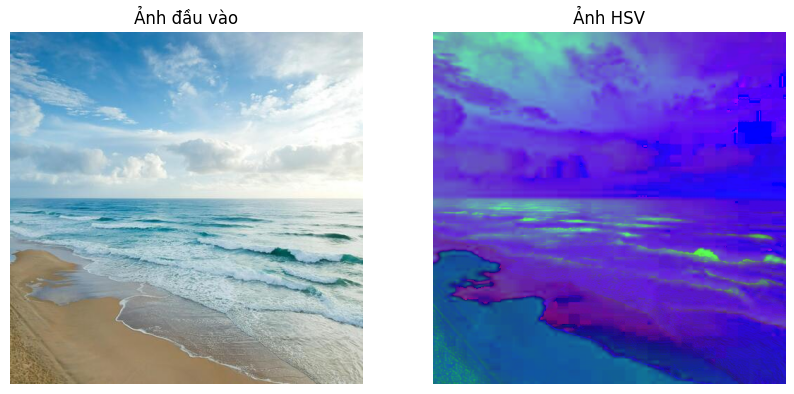

In [35]:
image = convert_to_rgb(image)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Ảnh đầu vào")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2HSV) )
plt.title("Ảnh HSV")
plt.axis('off')


plt.show()

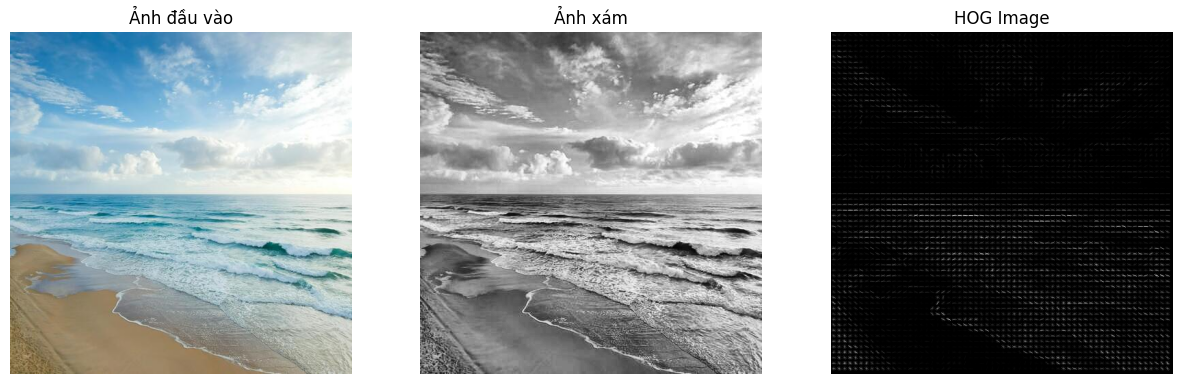

In [36]:
image = convert_to_rgb(image)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Ảnh đầu vào")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(convert_image_rgb_to_gray(image), cmap='gray')
plt.title("Ảnh xám")
plt.axis('off')


a, hogimg = hog_feature(convert_image_rgb_to_gray(image))
# Hiển thị hogImage
plt.subplot(1, 3, 3)
plt.imshow(hogimg, cmap='gray')
plt.title("HOG Image")
plt.axis('off')

plt.show()

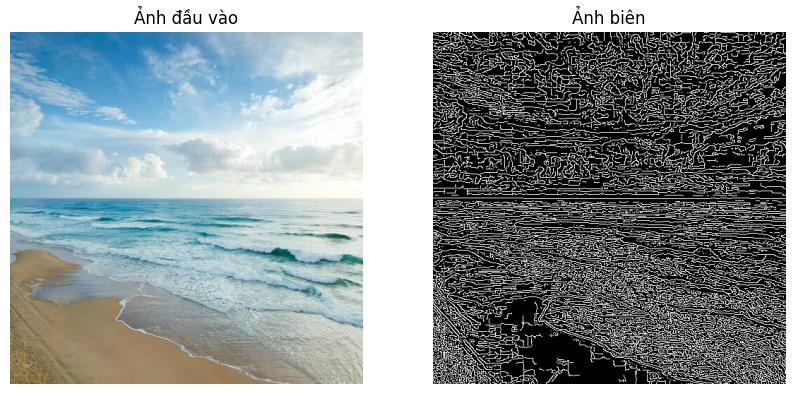

In [37]:
image = convert_to_rgb(image)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Ảnh đầu vào")
plt.axis('off')

edg_fl, edge_image = edge_feature(image)
plt.subplot(1, 2, 2)
plt.imshow(edge_image, cmap='gray')
plt.title("Ảnh biên")
plt.axis('off')


plt.show()

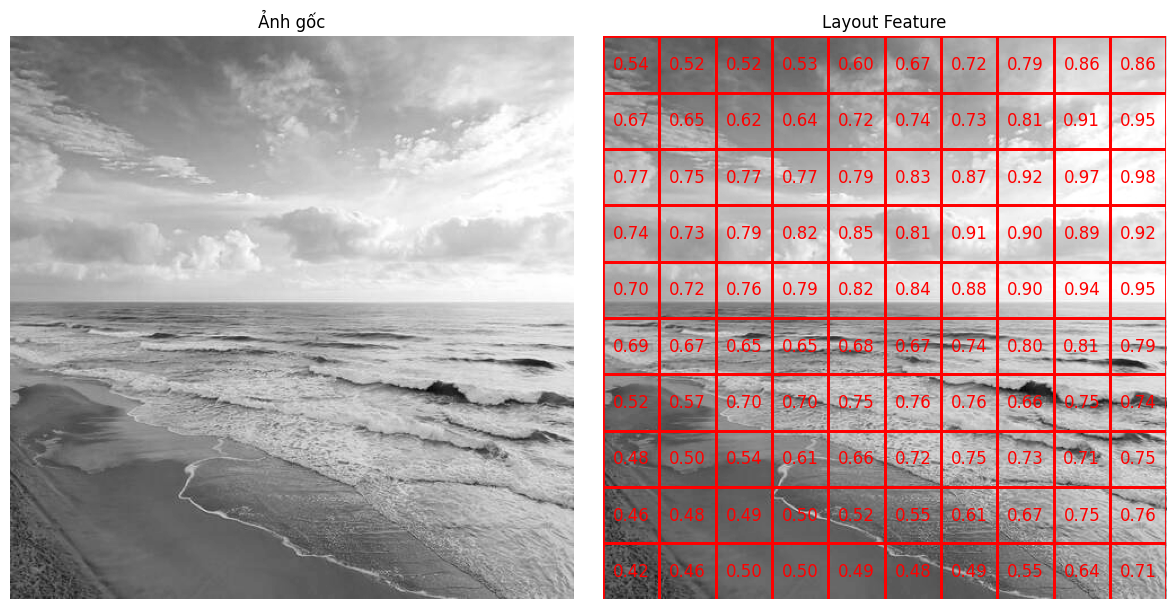

In [38]:
if len(image.shape) == 3:
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
features = layout_feature(image)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# Hiển thị ảnh gốc
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Ảnh gốc')
ax[0].axis('off')


# Hiển thị layout feature dưới dạng lưới
ax[1].imshow(image, cmap='gray')
height, width = image.shape
cell_height, cell_width = height // 10, width // 10
for i in range(10):
    for j in range(10):
        cell_value = features[i, j]
        rect = plt.Rectangle((j * cell_width, i * cell_height), cell_width, cell_height,
                             edgecolor='red', facecolor='none', linewidth=2)
        ax[1].add_patch(rect)
        ax[1].text(j * cell_width + cell_width / 2, i * cell_height + cell_height / 2,
                   f'{cell_value:.2f}', color='red', ha='center', va='center', fontsize=12)
ax[1].set_title('Layout Feature')
ax[1].axis('off')

# Hiển thị figure
plt.tight_layout()
plt.show()
